# Test MIO 
Read MIO, and psearch all BNODES, so we replace them when needed. 

In [1]:
from ontology_manager.ontology_utils import OntologyManager
from rdflib import Graph, URIRef, Namespace, Literal, BNode, collection
from rdflib.namespace import SKOS, RDF, RDFS, OWL

In [2]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph, rdflib_to_graphtool
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
from ontodot.ontodot import vis, filter_graph_by_string
from ontodot.ontodot import OntoVis

In [4]:
def printH(s):
    the_line = "=" * (len(s)+1)
    print(f"{s}:\n{the_line}")


<br>
Test import of a sane ontology like MIO. <br>


In [5]:
mio=Namespace("http://www.ddmd.io/mio/")

In [6]:
base_path = '../MIO/'
catalog_file = 'catalog-v001.xml'

In [7]:
mio_manager = OntologyManager(base_path, catalog_file)
mio_manager.parse_catalog()
mio_manager.load_ontology()

name= http://ddmd.io/mio/ uri= ./mio/mio.ttl
Loaded ontology: http://ddmd.io/mio/


In [8]:
# there is one graph, we also know the name space,
g=mio_manager.ontology_graphs["http://ddmd.io/mio/"]

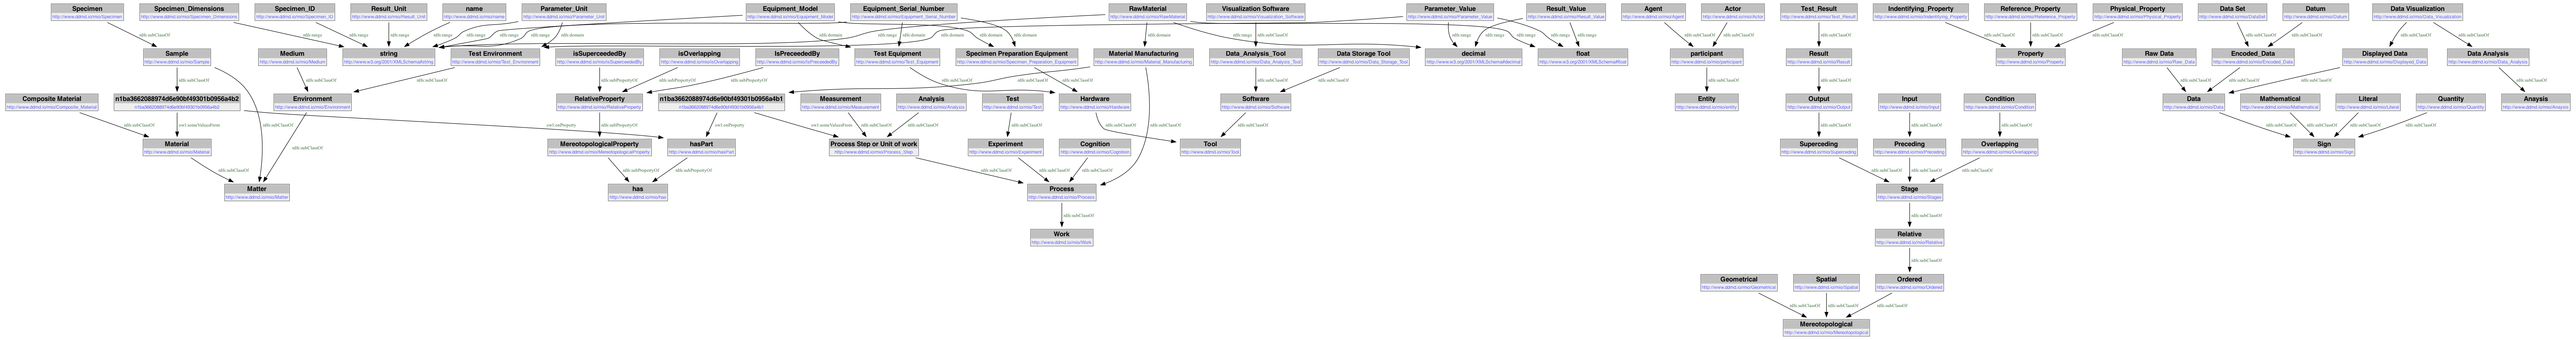

In [9]:
# plot, and check the OntoVis.Output folder for all images and dot files. 
vis(g, max_string_length=5)

In [10]:
# Find all classes that are not subclasses, i.e., those directly inheretting from OWL:Thing (which is 
# implicitly defined in OWL, but not found explicitly in the file. 

# this is the top ontology! we could make a function for it. 

query = """
    SELECT ?s ?p ?o
    WHERE {
        ?s a owl:Class .
        FILTER NOT EXISTS {
    ?s rdfs:subClassOf ?superclass .
  }
      ?s ?p ?o .
    }
"""
results = g.query(query)
len(results)

12

In [11]:
g_sub1=Graph()
for s, p, o in results:
    g_sub1.add((s,p,o))
g_sub1.bind("mio", mio)
print(g_sub1.serialize())

@prefix mio: <http://www.ddmd.io/mio/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

mio:Matter a owl:Class .

mio:Mereotopological a owl:Class ;
    rdfs:label "Mereotopological" ;
    rdfs:comment "In formal ontology, a branch of metaphysics, and in ontological computer science, mereotopology is a first-order theory, embodying mereological and topological concepts, of the relations among wholes, parts, parts of parts, and the boundaries between parts." .

mio:Property a owl:Class ;
    rdfs:comment "Represents an attribute, characteristic, or quality that can be used to describe and differentiate entities. Properties provide additional information about individuals (instances of classes) within a domain." .

mio:Sign a owl:Class .

mio:Tool a owl:Class .

mio:Work a owl:Class .

mio:entity a owl:Class ;
    rdfs:label "Entity" ;
    rdfs:comment "Represents the an entity as in individual, organisation, group that participat

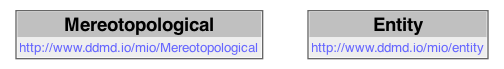

In [12]:
# visualise the top ontology categories 
vis(g_sub1, max_string_length=5)

In [13]:
ontovis_g=OntoVis(g) # to zoom into the graph
# zoom into classes only, i.e., find only "is-a" relations
# we could create a filter with multiple relations... 
# we can use rdflib directly, or the recursive find used in the ontovis class.. 

# loop over all the top level, and for each find the next level!
els =set()
printH(f"The Top Level Ontology Classes")
for s,_,_ in g_sub1: 
    print(s)
    els.add(s)


The Top Level Ontology Classes:
http://www.ddmd.io/mio/Work
http://www.ddmd.io/mio/Mereotopological
http://www.ddmd.io/mio/Mereotopological
http://www.ddmd.io/mio/entity
http://www.ddmd.io/mio/Property
http://www.ddmd.io/mio/Tool
http://www.ddmd.io/mio/entity
http://www.ddmd.io/mio/entity
http://www.ddmd.io/mio/Property
http://www.ddmd.io/mio/Matter
http://www.ddmd.io/mio/Mereotopological
http://www.ddmd.io/mio/Sign


In [14]:
g_zoom=ontovis_g.zoom_in("http://www.ddmd.io/mio/Matter", 2)

In [15]:
len(g_zoom)

17

http://www.ddmd.io/mio/Matter:
 found http://www.ddmd.io/mio/Matter graph with length 17:


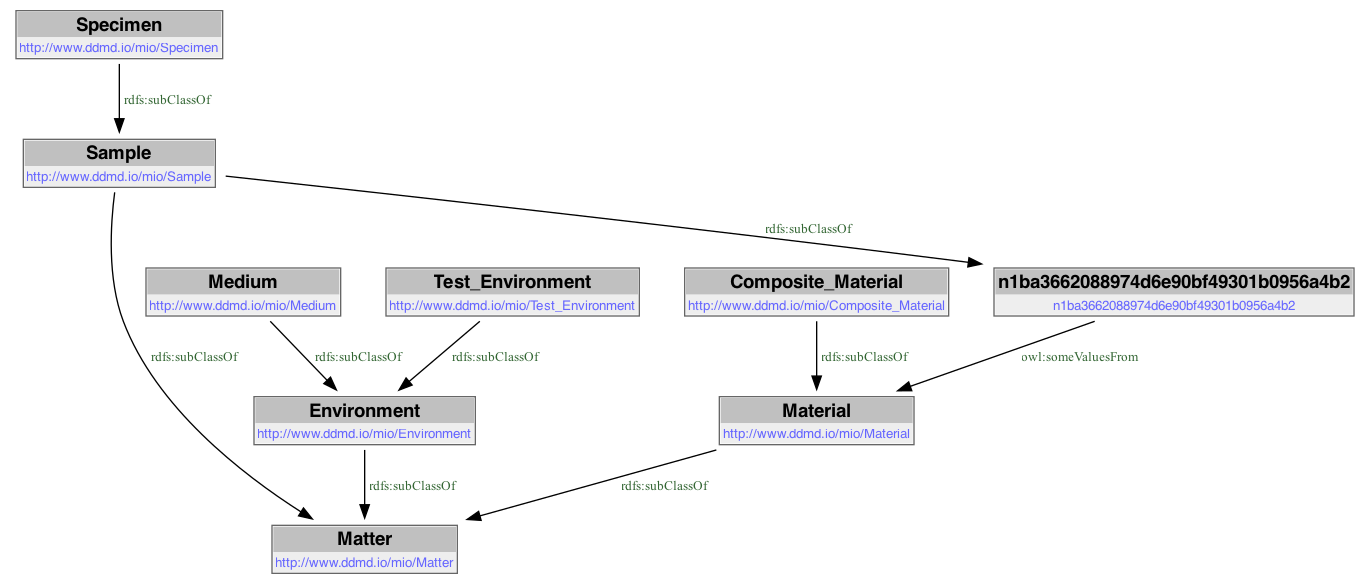

http://www.ddmd.io/mio/Tool:
 found http://www.ddmd.io/mio/Tool graph with length 9:


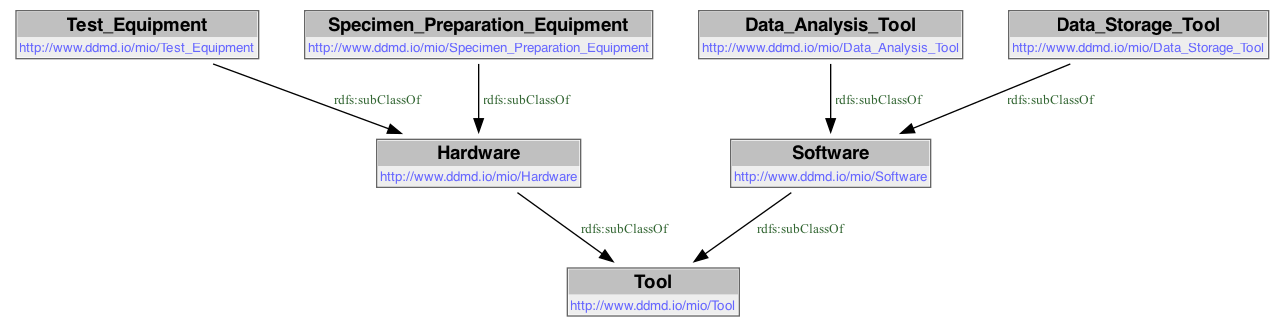

http://www.ddmd.io/mio/entity:
 found http://www.ddmd.io/mio/entity graph with length 8:


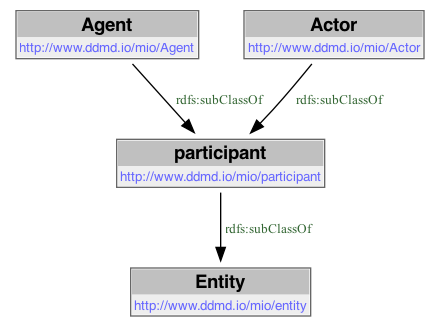

http://www.ddmd.io/mio/Work:
 found http://www.ddmd.io/mio/Work graph with length 7:


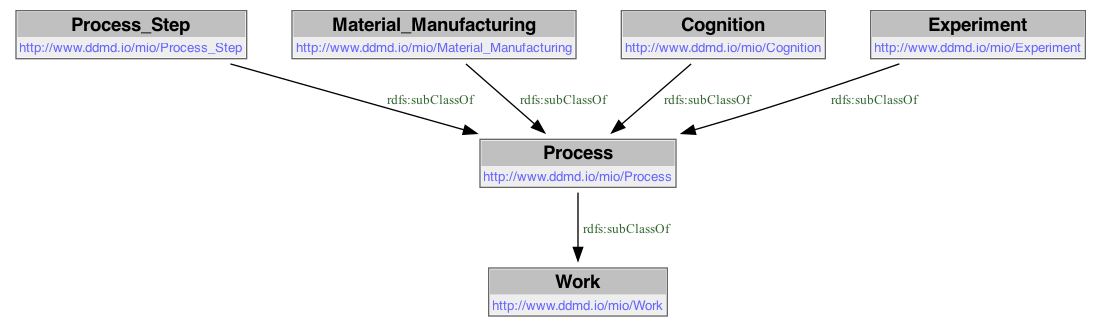

http://www.ddmd.io/mio/Mereotopological:
 found http://www.ddmd.io/mio/Mereotopological graph with length 16:


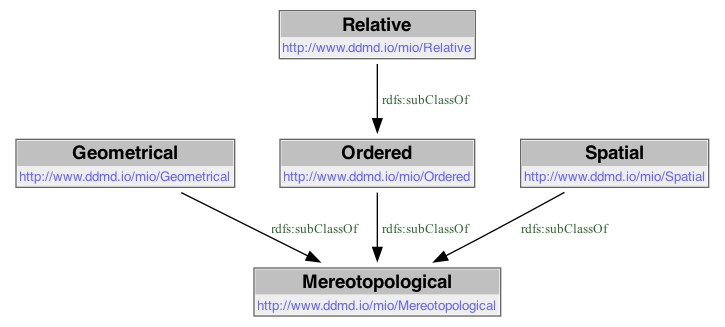

http://www.ddmd.io/mio/Property:
 found http://www.ddmd.io/mio/Property graph with length 8:


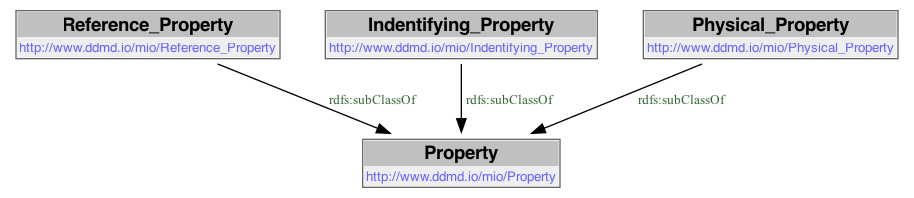

http://www.ddmd.io/mio/Sign:
 found http://www.ddmd.io/mio/Sign graph with length 14:


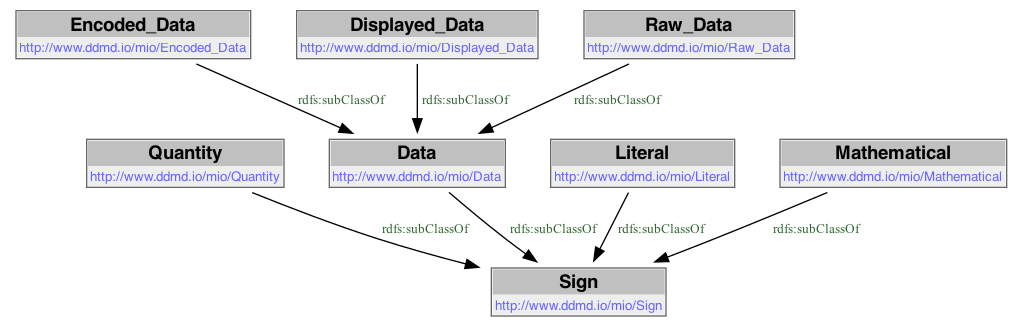

In [16]:
for i in els: 
    printH(f"{i}")
    #g_zoom=ontovis_g.zoom_in_classes(i, (1,1))
    g_zoom=ontovis_g.zoom_in(i, 2)
    printH(f" found {i} graph with length {len(g_zoom)}")
    vis(g_zoom)

In [17]:
def print_bnode_details(graph, bnode):
    recurse_bnode(graph, bnode)

def recurse_bnode(g, node, depth=0):
    indent = "     " * depth
    for s, p, o in g.triples((node, None, None)):
        print(f"{indent}{s} \t {p} \t {o}")
        if isinstance(o, BNode) and o != node:
            recurse_bnode(g, o, depth + 1)
    for s, p, o in g.triples((None, None, node)):
        if s != node:
            print(f"{indent}{s} \t {p} \t {o}")
            if isinstance(s, BNode):
                recurse_bnode(g, s, depth + 1)

def is_bnode(node):
    if isinstance(node, BNode):
        return str(node)  # Return the UUID of the BNode
    return None  # Return None if it's not a BNode


for s,p,o in g: 
    if (bnode_uuid := is_bnode(s)):   # using the "warlos operator!" 
        print("\n")
        print_bnode_details(g, s)
        print("\n")
        # Do something with the BNode
    





n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/1999/02/22-rdf-syntax-ns#type 	 http://www.w3.org/2002/07/owl#Restriction
n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/2002/07/owl#onProperty 	 http://www.ddmd.io/mio/hasPart
n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/2002/07/owl#someValuesFrom 	 http://www.ddmd.io/mio/Material
http://www.ddmd.io/mio/Sample 	 http://www.w3.org/2000/01/rdf-schema#subClassOf 	 n1ba3662088974d6e90bf49301b0956a4b2




n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/1999/02/22-rdf-syntax-ns#type 	 http://www.w3.org/2002/07/owl#Restriction
n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/2002/07/owl#onProperty 	 http://www.ddmd.io/mio/hasPart
n1ba3662088974d6e90bf49301b0956a4b2 	 http://www.w3.org/2002/07/owl#someValuesFrom 	 http://www.ddmd.io/mio/Material
http://www.ddmd.io/mio/Sample 	 http://www.w3.org/2000/01/rdf-schema#subClassOf 	 n1ba3662088974d6e90bf49301b0956a4b2




n1ba3662088974d6e90bf49301b0956a4b1 

In [18]:
g5=ontovis_g.zoom_in(mio.Material_Manufacturing, 2)
#g5=ontovis.zoom_in(mio.Data_Analysis, 2)
#ontodot.vis(g5, max_string_length=5)



hello: n1ba3662088974d6e90bf49301b0956a4b1


In [19]:
g6=ontovis_g.zoom_in(BNode('na19da294384b489b913d918890bcf7ecb1'), 1)
print(g6.serialize())


In [20]:
g7=g6+g5

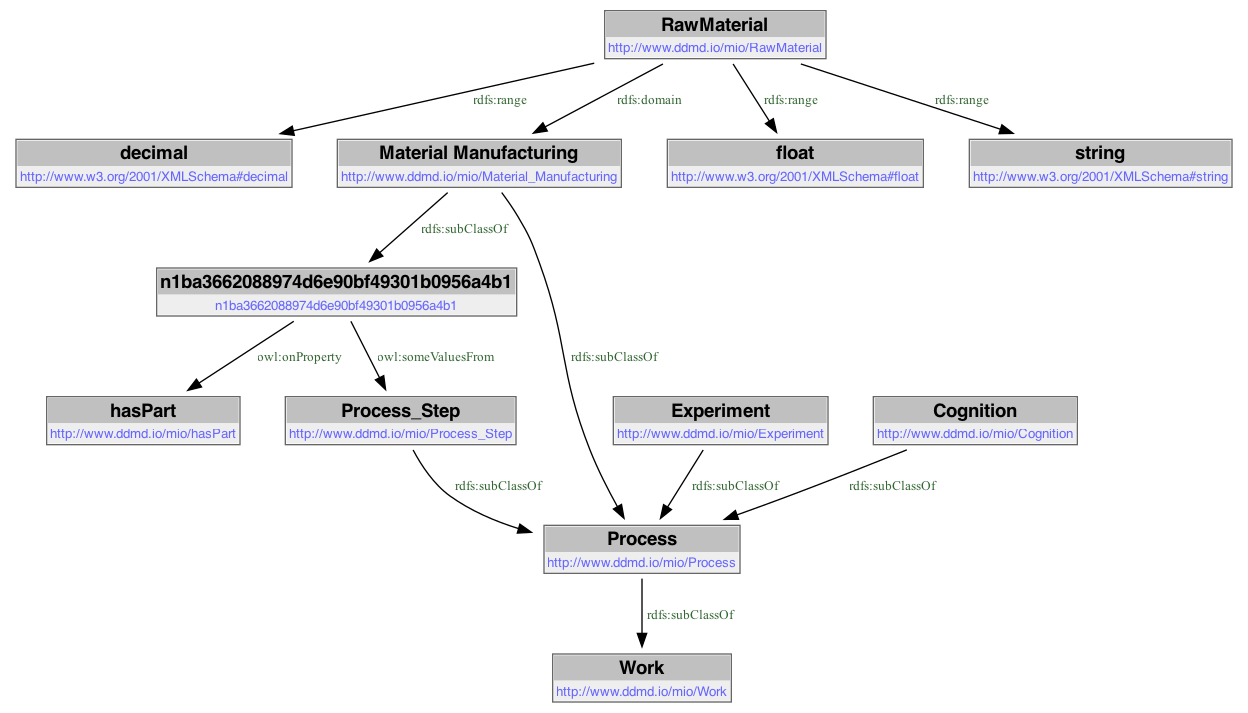

In [21]:
vis(g7)

In [22]:
query = """
    SELECT ?s ?p ?o
    WHERE {
        {BIND (<%s> as ?s)
        { ?s ?p ?o  }} UNION
        {BIND (<%s> as ?o)
        { ?s ?p ?o  }} 
    }
""" % (BNode("n6a6f193c7c4e49bcba12ebe1edb6f902b1"), BNode("n6a6f193c7c4e49bcba12ebe1edb6f902b1"))

In [23]:
for s, p, o in g.query(query):
    print (s, p, o)

In [24]:
ontovis_g.explode_bnode(g, BNode("na19da294384b489b913d918890bcf7ecb1"))

In [25]:
gf=filter_graph_by_string(g, "mater")
print(len(gf))
#gf.serialize()

26


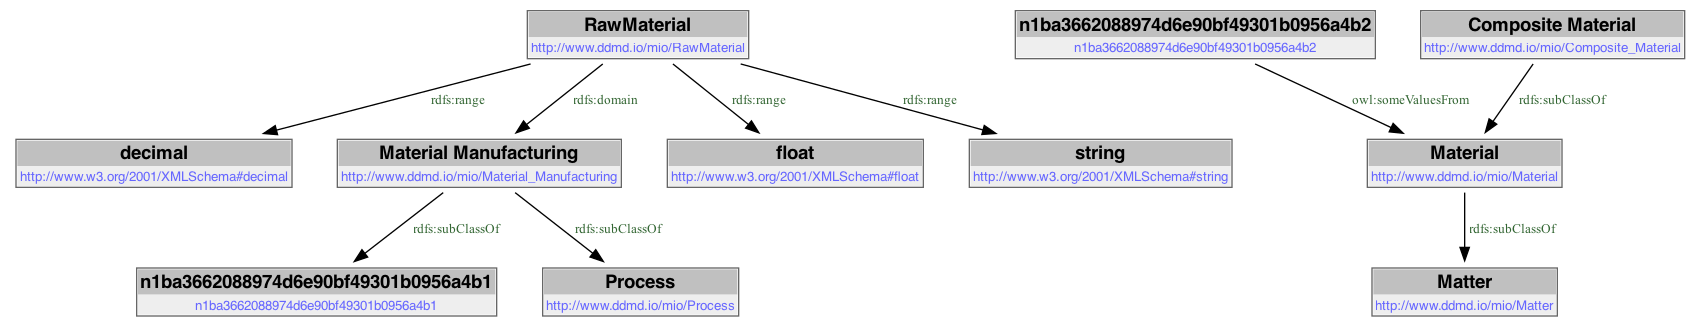

In [26]:
vis(gf)


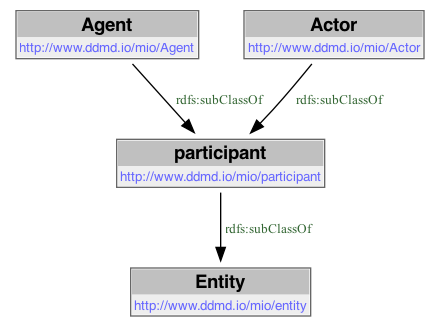

In [27]:
g_zoom=ontovis_g.zoom_in("http://www.ddmd.io/mio/entity", 5)
vis(g_zoom)